In [3]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [5]:
#loading data 
data_dir =r"D:\Perkuliahan\semester 6\Metodologi Penelitian\cnn&svm\penyakit_daun_mangga"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [7]:
# Preprocessing the images with a flip ,zoom , rotation and shift using imagedatagenerator 
batch_size = 32
img_size = (200, 250)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
print(batch_size)

  
tr_gen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2,horizontal_flip=True,zoom_range=0.3,rotation_range =0.2)
ts_gen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2,horizontal_flip=True,zoom_range=0.3,rotation_range =0.2)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

32
Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


In [8]:
num_augmented_images = train_gen.n - len(train_gen.filepaths)
print(num_augmented_images)
print(train_gen.samples)

0
2800


In [9]:
train_gen.n
label_to_index = train_gen.class_indices

# Get the number of samples per label
num_samples_per_label = {class_name: 0 for class_name in label_to_index}

# Count the number of samples per label
for i in range(train_gen.samples // 32 + 1):
    _, labels = train_gen[i]
    for label in labels:
        class_name = list(label_to_index.keys())[list(label_to_index.values()).index(label.argmax())]
        num_samples_per_label[class_name] += 1

# Print the number of samples per label
for class_name, num_samples in num_samples_per_label.items():
    print(f"Class {class_name}: {num_samples} samples")

Class Anthracnose: 365 samples
Class Bacterial Canker: 322 samples
Class Cutting Weevil: 348 samples
Class Die Back: 354 samples
Class Gall Midge: 365 samples
Class Healthy: 350 samples
Class Powdery Mildew: 353 samples
Class Sooty Mould: 343 samples


In [10]:
valid_gen.n
label_to_index = train_gen.class_indices

# Get the number of samples per label
num_samples_per_label = {class_name: 0 for class_name in label_to_index}

# Count the number of samples per label
for i in range(valid_gen.samples // 32 + 1):
    _, labels = valid_gen[i]
    for label in labels:
        class_name = list(label_to_index.keys())[list(label_to_index.values()).index(label.argmax())]
        num_samples_per_label[class_name] += 1

# Print the number of samples per label
for class_name, num_samples in num_samples_per_label.items():
    print(f"Class {class_name}: {num_samples} samples")

Class Anthracnose: 70 samples
Class Bacterial Canker: 95 samples
Class Cutting Weevil: 78 samples
Class Die Back: 67 samples
Class Gall Midge: 61 samples
Class Healthy: 75 samples
Class Powdery Mildew: 70 samples
Class Sooty Mould: 84 samples


In [11]:
print(test_gen.n)
label_to_index = test_gen.class_indices

# Get the number of samples per label
num_samples_per_label = {class_name: 0 for class_name in label_to_index}

# Count the number of samples per label
for i in range(len(test_gen)):
    _, labels = test_gen[i]
    for label in labels:
        class_name = list(label_to_index.keys())[list(label_to_index.values()).index(label.argmax())]
        num_samples_per_label[class_name] += 1

# Print the number of samples per label
for class_name, num_samples in num_samples_per_label.items():
    print(f"Class {class_name}: {num_samples} samples")


600
Class Anthracnose: 65 samples
Class Bacterial Canker: 83 samples
Class Cutting Weevil: 74 samples
Class Die Back: 79 samples
Class Gall Midge: 74 samples
Class Healthy: 75 samples
Class Powdery Mildew: 77 samples
Class Sooty Mould: 73 samples


In [12]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

img_size = (200, 250)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# Creating the model using the predefine efficentNetB5 and adding the additional layers 
base_model = tf.keras.applications.EfficientNetB5(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
   
)
base_model.trainable = True


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.06),
                bias_regularizer= regularizers.l1(0.06), activation= 'relu'),
    Dropout(rate = 0.4),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 1000)              30562527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1000)              4000      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 30824839 (117.59 MB)
Trainable params: 306

In [13]:

batch_size = 32 # set batch size for training
epochs = 12   # number of all epochs in training

history = model.fit_generator( train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/12
88/88 [==============================] - 1336s 15s/step - loss: 4.3753 - accuracy: 0.2914 - val_loss: 2.5701 - val_accuracy: 0.2167
Epoch 2/12
88/88 [==============================] - 1250s 14s/step - loss: 2.2431 - accuracy: 0.3204 - val_loss: 2.1642 - val_accuracy: 0.1300
Epoch 3/12
88/88 [==============================] - 1194s 14s/step - loss: 2.0133 - accuracy: 0.3407 - val_loss: 2.0780 - val_accuracy: 0.3367
Epoch 4/12
 1/88 [..............................] - ETA: 23:06 - loss: 1.9934 - accuracy: 0.4375

In [1]:

model.summary()

NameError: name 'model' is not defined

In [2]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

NameError: name 'history' is not defined

8/8 [==============================] - 13s 1s/step - loss: 0.6704 - accuracy: 0.9983
Train Loss:  0.6789067387580872
Train Accuracy:  0.99609375
--------------------
Validation Loss:  0.6677836179733276
Validation Accuracy:  1.0
--------------------
Test Loss:  0.6704446077346802
Test Accuracy:  0.9983333349227905


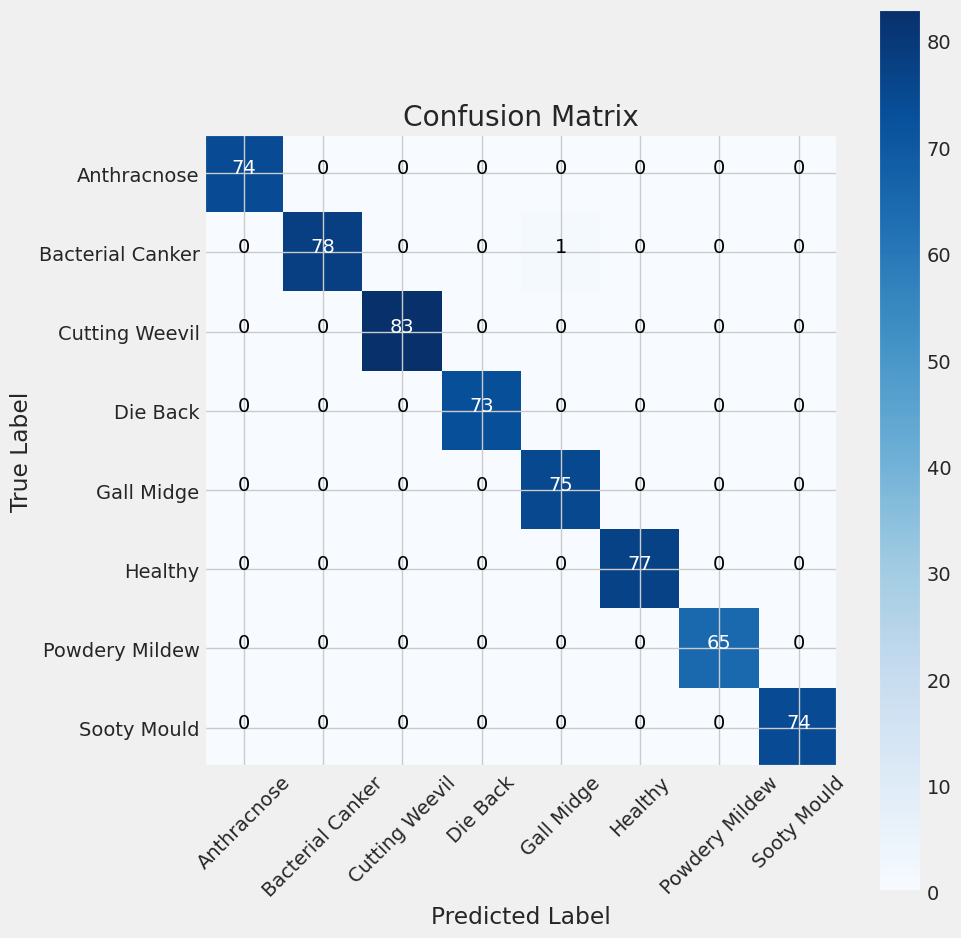

In [30]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
print("DENSENET121")
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model = tf.keras.applications.DenseNet121(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
   
)
base_model.trainable = True 


model_denseNet = Sequential([
    base_model,
    Dense(class_count, activation= 'softmax')
])

model_denseNet.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model_denseNet.summary()

DENSENET121
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1000)              8062504   
                                                                 
 dense_2 (Dense)             (None, 8)                 8008      
                                                                 
Total params: 8,070,512
Trainable params: 7,986,864
Non-trainable params: 83,648
_________________________________________________________________


In [17]:

batch_size = 32 # set batch size for training
epochs = 12  # number of all epochs in training

history_dense = model_denseNet.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/12
88/88 [==============================] - 156s 908ms/step - loss: 1.9915 - accuracy: 0.8129 - val_loss: 1.9935 - val_accuracy: 0.6750
Epoch 2/12
88/88 [==============================] - 51s 576ms/step - loss: 1.9147 - accuracy: 0.9557 - val_loss: 1.8800 - val_accuracy: 0.9617
Epoch 3/12
88/88 [==============================] - 50s 561ms/step - loss: 1.8518 - accuracy: 0.9571 - val_loss: 1.8717 - val_accuracy: 0.7733
Epoch 4/12
88/88 [==============================] - 50s 571ms/step - loss: 1.7872 - accuracy: 0.9725 - val_loss: 1.8243 - val_accuracy: 0.7850
Epoch 5/12
88/88 [==============================] - 50s 561ms/step - loss: 1.7266 - accuracy: 0.9761 - val_loss: 1.7290 - val_accuracy: 0.9150
Epoch 6/12
88/88 [==============================] - 49s 559ms/step - loss: 1.6631 - accuracy: 0.9861 - val_loss: 1.6307 - val_accuracy: 0.9867
Epoch 7/12
88/88 [==============================] - 50s 567ms/step - loss: 1.6012 - accuracy: 0.9896 - val_loss: 1.5662 - val_accuracy: 0.995

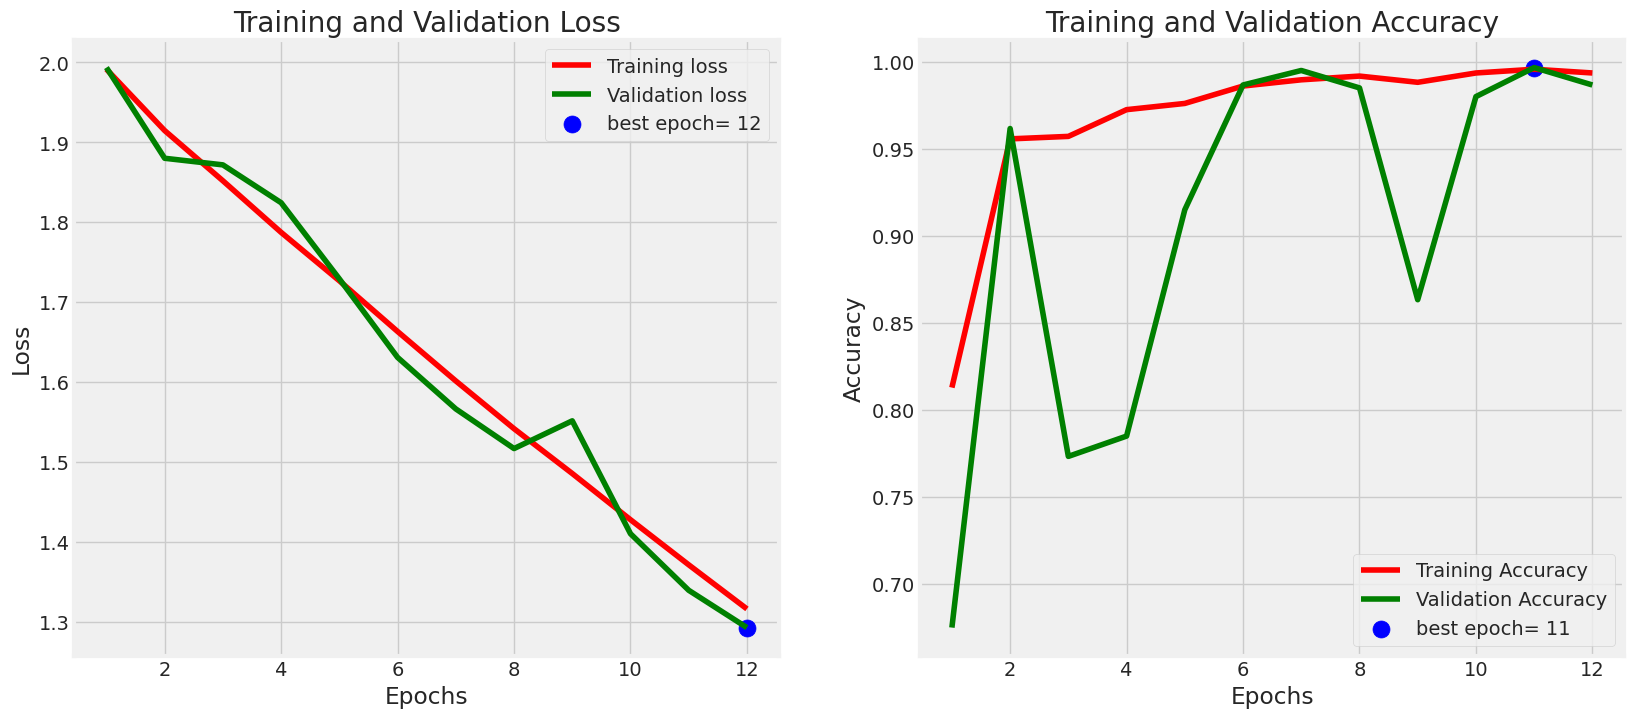

8/8 [==============================] - 14s 1s/step - loss: 1.2950 - accuracy: 0.9883
Train Loss:  1.2964646816253662
Train Accuracy:  0.98046875
--------------------
Validation Loss:  1.3003379106521606
Validation Accuracy:  0.98046875
--------------------
Test Loss:  1.2950100898742676
Test Accuracy:  0.9883333444595337


In [18]:

tr_acc = history_dense.history['accuracy']
tr_loss = history_dense.history['loss']
val_acc = history_dense.history['val_accuracy']
val_loss = history_dense.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_denseNet.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model_denseNet.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model_denseNet.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

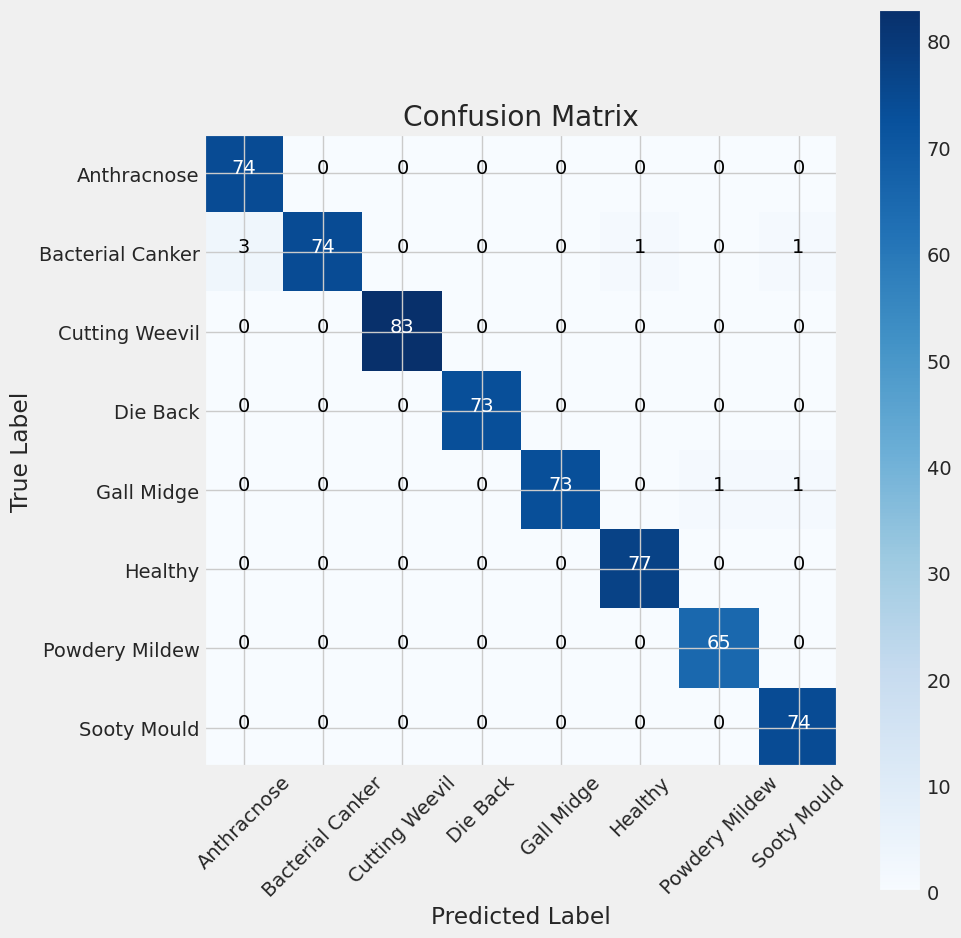

In [19]:
preds = model_denseNet.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [22]:
print('MobileNet')
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

img_size = (200, 250)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# Creating the model using the predefine efficentNetB5 and adding the additional layers 
base_model = tf.keras.applications.MobileNet(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
   
)
base_model.trainable = True


model_mobilenet = Sequential([
    base_model,
    Dense(class_count, activation= 'softmax')
])

model_mobilenet.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model_mobilenet.summary()

MobileNet
17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 8)                 8008      
                                                                 
Total params: 4,261,872
Trainable params: 4,239,984
Non-trainable params: 21,888
_________________________________________________________________


In [23]:

batch_size =  32 # set batch size for training
epochs = 12   # number of all epochs in training

history_mn = model_mobilenet.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/12


2023-05-29 18:53:30.788707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/mobilenet_1.00_224/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


88/88 [==============================] - 58s 495ms/step - loss: 1.9989 - accuracy: 0.6954 - val_loss: 1.9847 - val_accuracy: 0.6700
Epoch 2/12
88/88 [==============================] - 43s 494ms/step - loss: 1.9223 - accuracy: 0.9132 - val_loss: 1.9058 - val_accuracy: 0.8817
Epoch 3/12
88/88 [==============================] - 43s 483ms/step - loss: 1.8583 - accuracy: 0.9700 - val_loss: 1.8270 - val_accuracy: 0.9750
Epoch 4/12
88/88 [==============================] - 43s 488ms/step - loss: 1.7939 - accuracy: 0.9836 - val_loss: 1.7695 - val_accuracy: 0.9633
Epoch 5/12
88/88 [==============================] - 43s 487ms/step - loss: 1.7330 - accuracy: 0.9861 - val_loss: 1.6981 - val_accuracy: 0.9917
Epoch 6/12
88/88 [==============================] - 43s 487ms/step - loss: 1.6704 - accuracy: 0.9896 - val_loss: 1.6377 - val_accuracy: 0.9900
Epoch 7/12
88/88 [==============================] - 43s 485ms/step - loss: 1.6126 - accuracy: 0.9879 - val_loss: 1.5803 - val_accuracy: 0.9933
Epoch 8/12

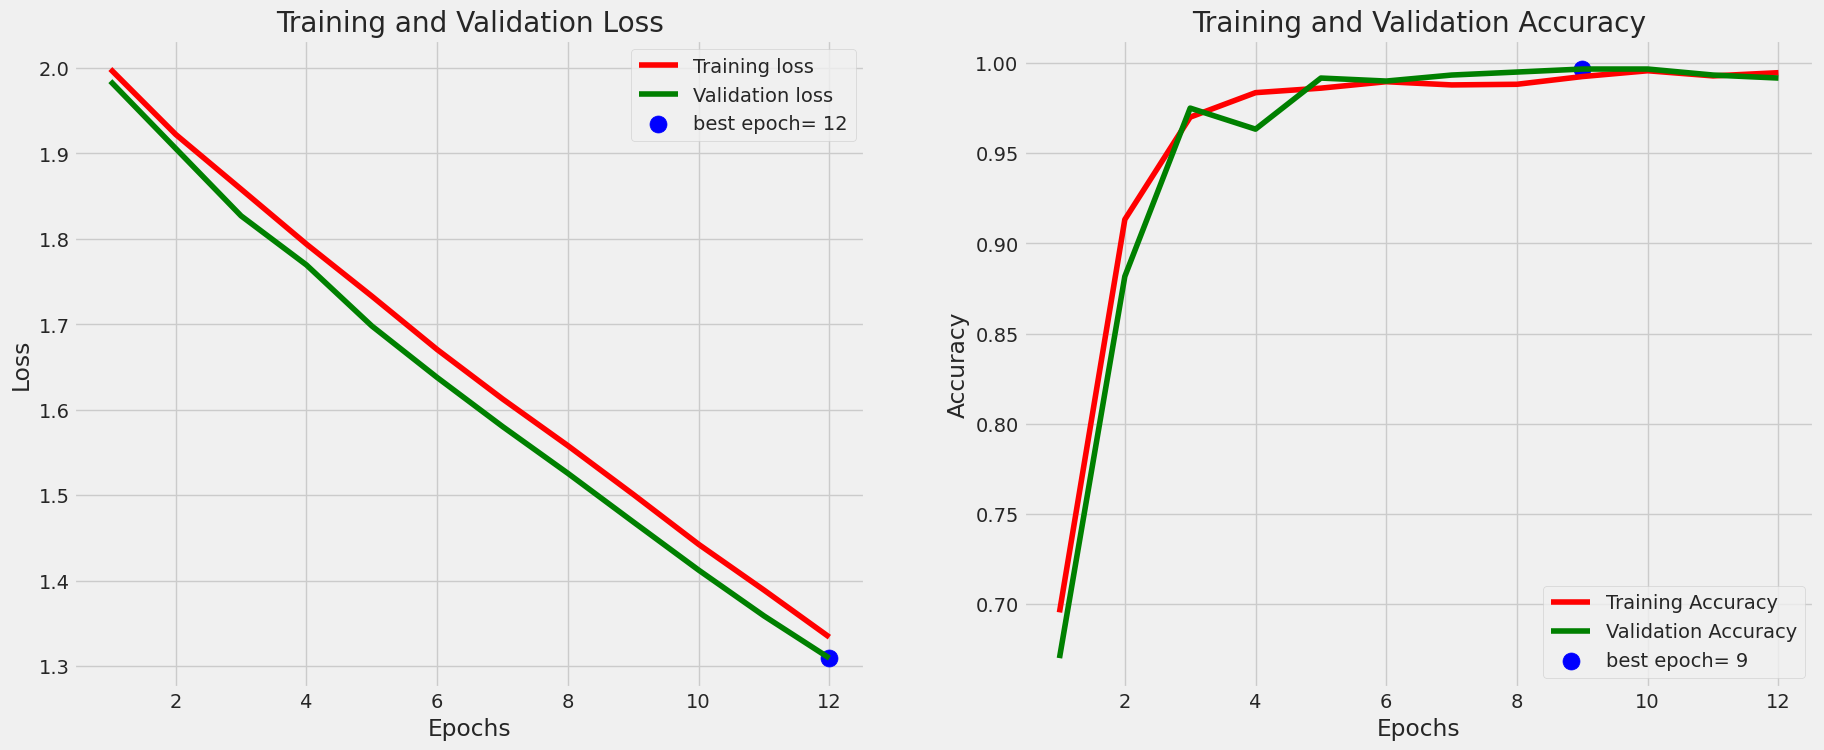

8/8 [==============================] - 8s 878ms/step - loss: 1.3112 - accuracy: 0.9900
Train Loss:  1.30143404006958
Train Accuracy:  1.0
--------------------
Validation Loss:  1.303106427192688
Validation Accuracy:  0.99609375
--------------------
Test Loss:  1.3111722469329834
Test Accuracy:  0.9900000095367432


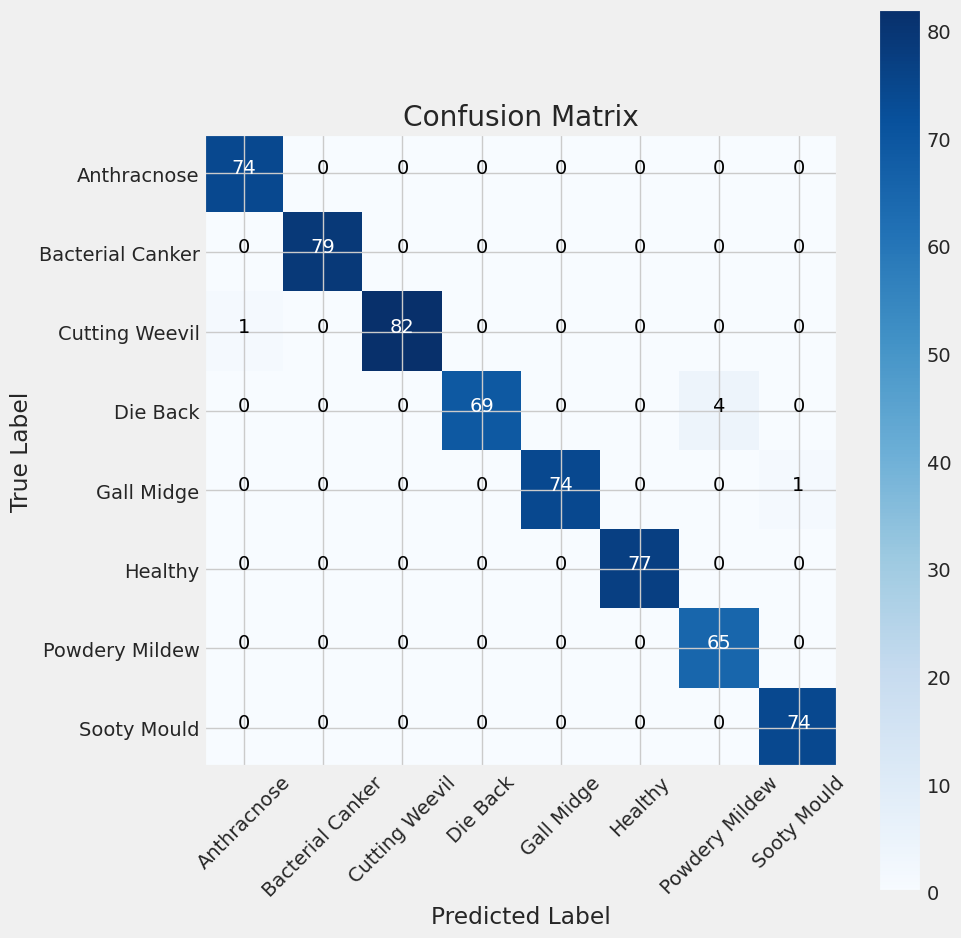

In [24]:

tr_acc = history_mn.history['accuracy']
tr_loss = history_mn.history['loss']
val_acc = history_mn.history['val_accuracy']
val_loss = history_mn.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_mobilenet.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model_mobilenet.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model_mobilenet.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
preds = model_mobilenet.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [25]:
print('Xception')
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

img_size = (200, 250)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# Creating the model using the predefine efficentNetB5 and adding the additional layers 
base_model = tf.keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
   
)
base_model.trainable = True


model_x = Sequential([
    base_model,
    Dense(class_count, activation= 'softmax')
])

model_x.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model_x.summary()

Xception
91884032/91884032 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 1000)              22910480  
                                                                 
 dense_4 (Dense)             (None, 8)                 8008      
                                                                 
Total params: 22,918,488
Trainable params: 22,863,960
Non-trainable params: 54,528
_________________________________________________________________


In [26]:

batch_size = 32 # set batch size for training
epochs = 10  # number of all epochs in training

history_x = model_x.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/10
88/88 [==============================] - 91s 695ms/step - loss: 1.9922 - accuracy: 0.7500 - val_loss: 1.9519 - val_accuracy: 0.8300
Epoch 2/10
88/88 [==============================] - 55s 621ms/step - loss: 1.9104 - accuracy: 0.8550 - val_loss: 1.8735 - val_accuracy: 0.8783
Epoch 3/10
88/88 [==============================] - 54s 610ms/step - loss: 1.8441 - accuracy: 0.8564 - val_loss: 1.8083 - val_accuracy: 0.8817
Epoch 4/10
88/88 [==============================] - 54s 609ms/step - loss: 1.7801 - accuracy: 0.8586 - val_loss: 1.7473 - val_accuracy: 0.8783
Epoch 5/10
88/88 [==============================] - 54s 610ms/step - loss: 1.7183 - accuracy: 0.8579 - val_loss: 1.6947 - val_accuracy: 0.8567
Epoch 6/10
88/88 [==============================] - 54s 608ms/step - loss: 1.6546 - accuracy: 0.8632 - val_loss: 1.6231 - val_accuracy: 0.8800
Epoch 7/10
88/88 [==============================] - 57s 645ms/step - loss: 1.5962 - accuracy: 0.8643 - val_loss: 1.5652 - val_accuracy: 0.8817

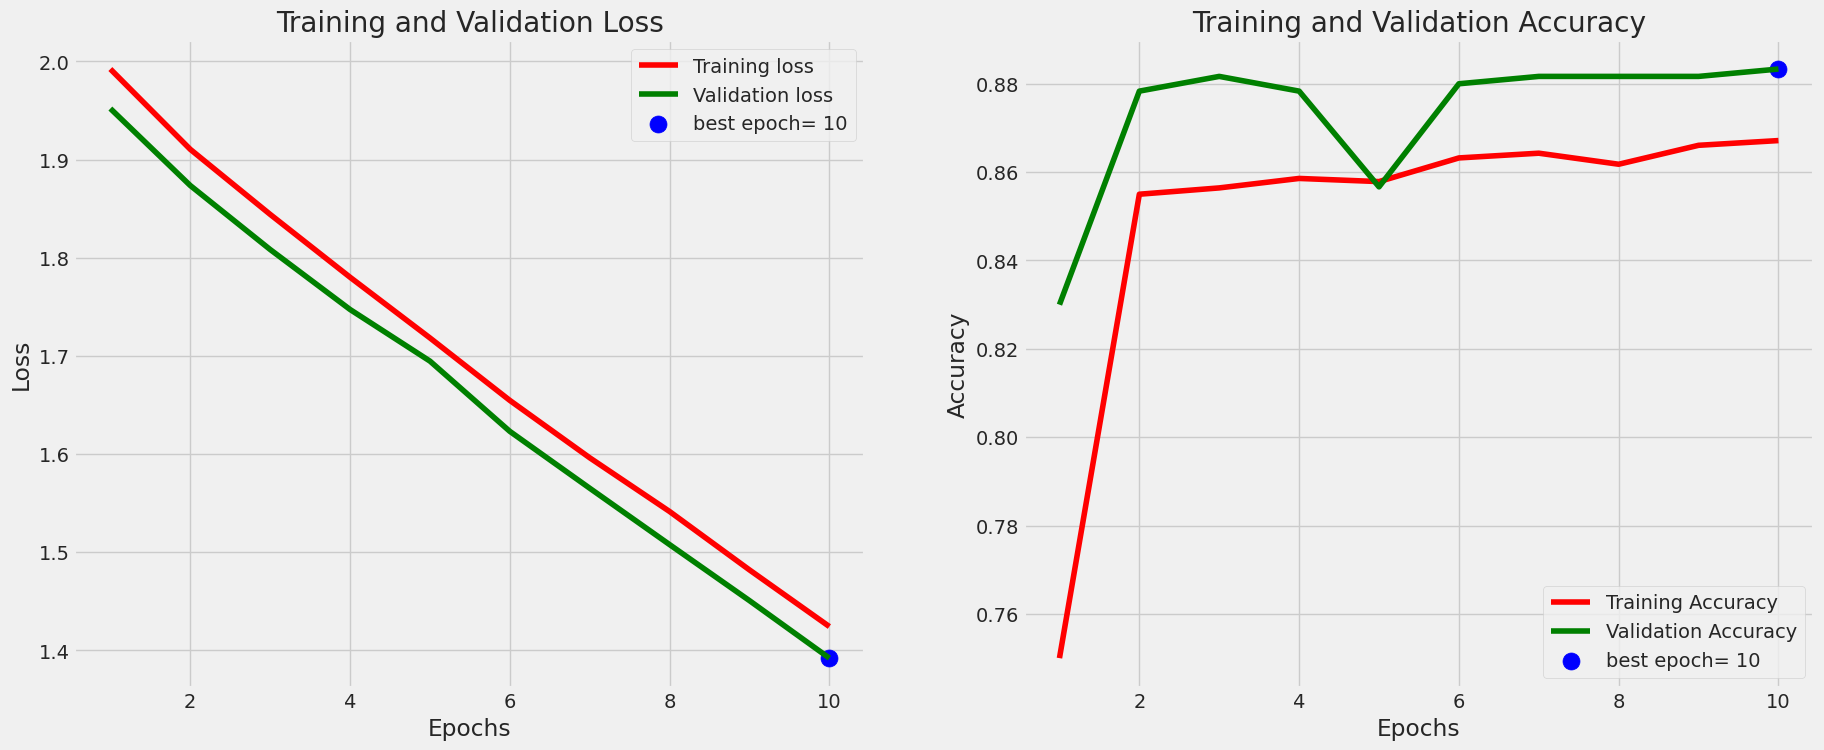

8/8 [==============================] - 11s 925ms/step - loss: 1.3930 - accuracy: 0.8900
Train Loss:  1.389866590499878
Train Accuracy:  0.8828125
--------------------
Validation Loss:  1.3912276029586792
Validation Accuracy:  0.90234375
--------------------
Test Loss:  1.3930022716522217
Test Accuracy:  0.8899999856948853


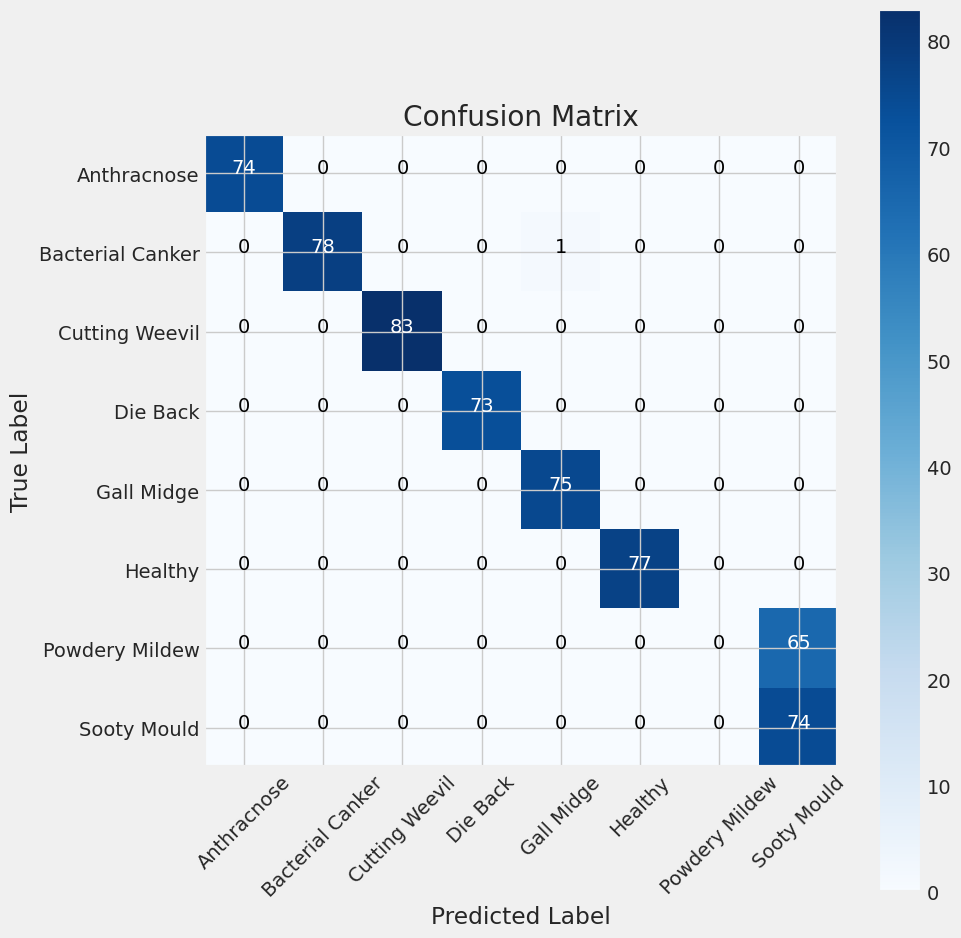

In [27]:

tr_acc = history_x.history['accuracy']
tr_loss = history_x.history['loss']
val_acc = history_x.history['val_accuracy']
val_loss = history_x.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_x.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model_x.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model_x.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
preds = model_x.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adamax

img_size = (200, 250)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(train_gen.class_indices)

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape
)

base_model.trainable  = True
output = Dense(class_count, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=output)

model_vgg.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg.summary()

batch_size = 32
epochs = 10

history_vgg = model_vgg.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 125, 128)     147584    
                                                              

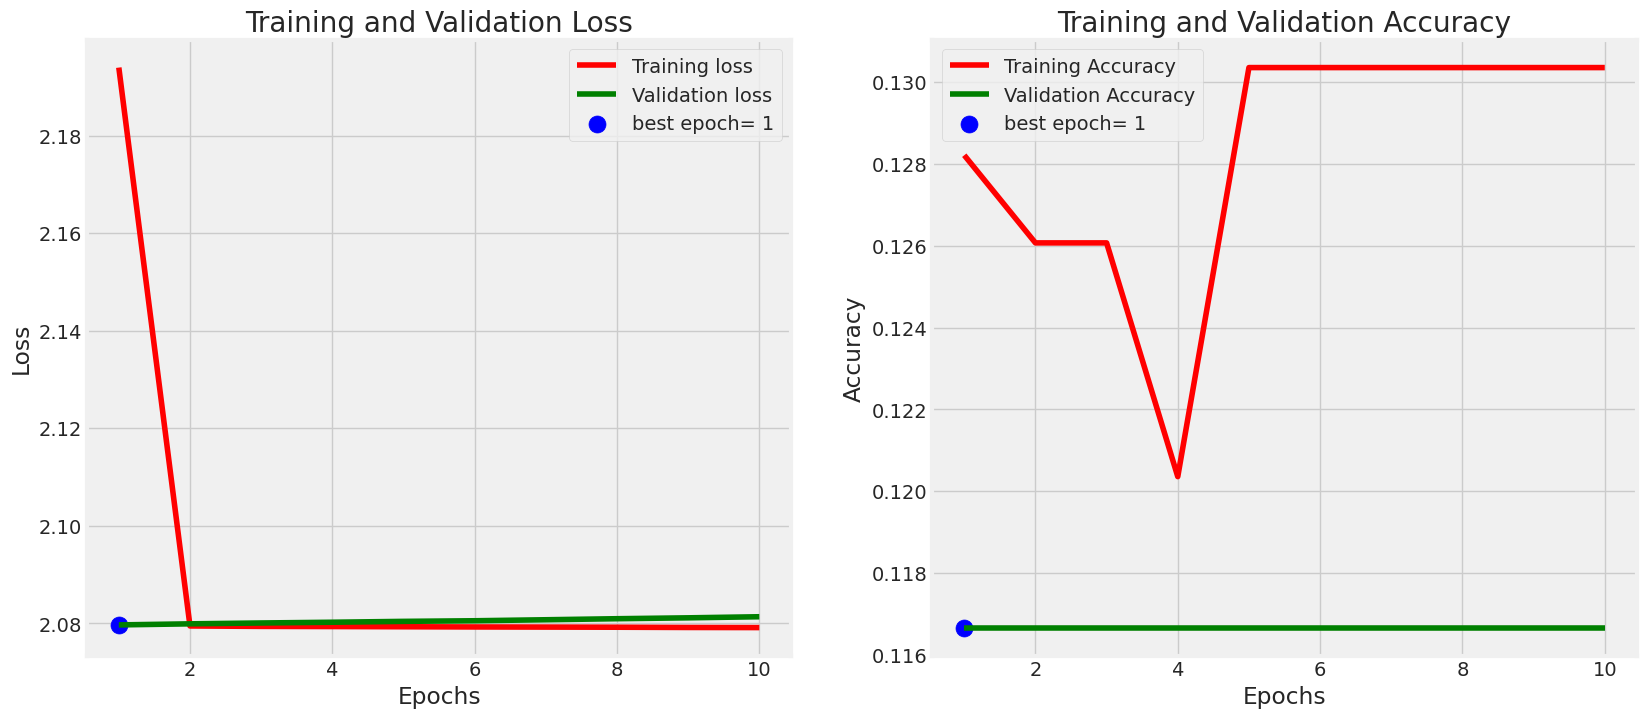

8/8 [==============================] - 19s 1s/step - loss: 2.0802 - accuracy: 0.1083
Train Loss:  2.079993963241577
Train Accuracy:  0.12890625
--------------------
Validation Loss:  2.0804009437561035
Validation Accuracy:  0.125
--------------------
Test Loss:  2.0802290439605713
Test Accuracy:  0.10833333432674408


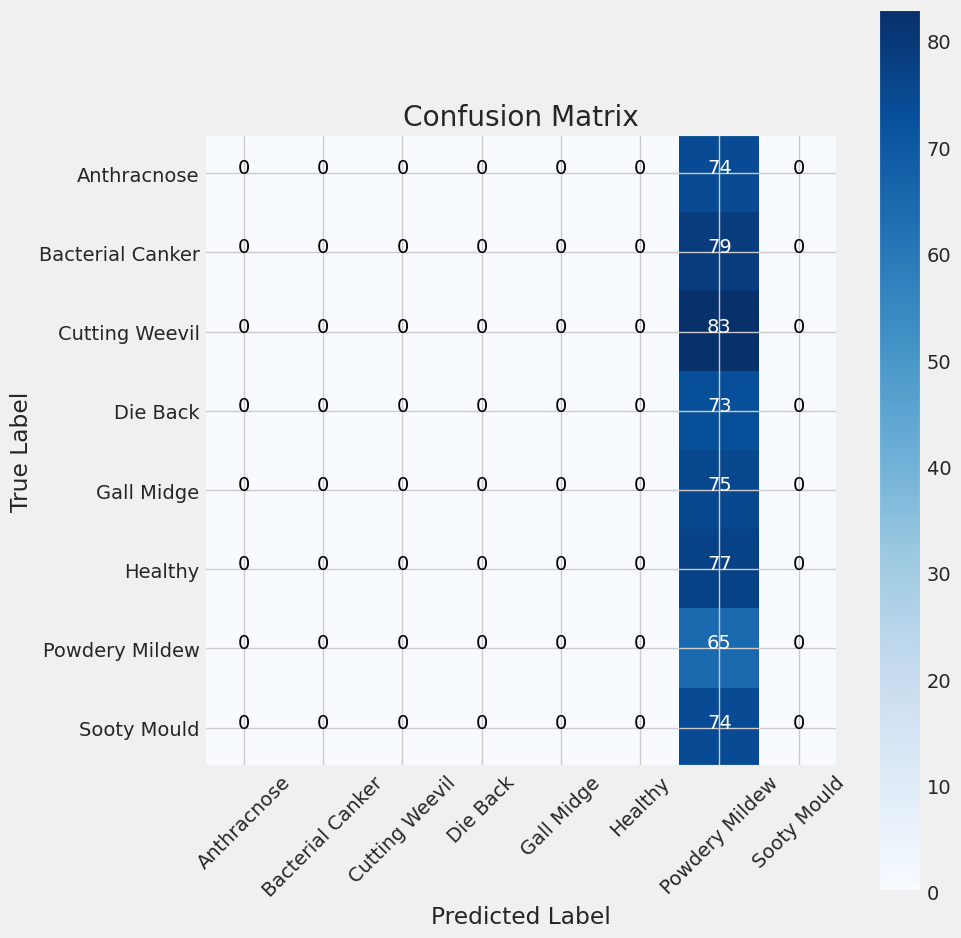

In [13]:

tr_acc = history_vgg.history['accuracy']
tr_loss = history_vgg.history['loss']
val_acc = history_vgg.history['val_accuracy']
val_loss = history_vgg.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_vgg.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model_vgg.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model_vgg.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
preds = model_vgg.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
print('ResNet50')
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

img_size = (200, 250)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# Creating the model using the predefine efficentNetB5 and adding the additional layers 
base_model = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
   
)
base_model.trainable = True


model_res = Sequential([
    base_model,
    Dense(class_count, activation= 'softmax')
])

model_res.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model_res.summary()

ResNet50
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_9 (Dense)             (None, 8)                 8008      
                                                                 
Total params: 25,644,720
Trainable params: 25,591,600
Non-trainable params: 53,120
_________________________________________________________________


In [18]:

batch_size =   32 # set batch size for training
epochs = 12  # number of all epochs in training

history_res = model_res.fit_generator(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/12
88/88 [==============================] - 94s 654ms/step - loss: 2.0032 - accuracy: 0.7193 - val_loss: 2.0130 - val_accuracy: 0.5600
Epoch 2/12
88/88 [==============================] - 51s 577ms/step - loss: 1.9371 - accuracy: 0.8864 - val_loss: 1.9755 - val_accuracy: 0.5783
Epoch 3/12
88/88 [==============================] - 51s 575ms/step - loss: 1.8785 - accuracy: 0.9054 - val_loss: 1.8461 - val_accuracy: 0.9383
Epoch 4/12
88/88 [==============================] - 51s 584ms/step - loss: 1.8203 - accuracy: 0.9321 - val_loss: 1.8201 - val_accuracy: 0.8267
Epoch 5/12
88/88 [==============================] - 50s 567ms/step - loss: 1.7631 - accuracy: 0.9357 - val_loss: 1.8305 - val_accuracy: 0.7233
Epoch 6/12
88/88 [==============================] - 50s 571ms/step - loss: 1.7099 - accuracy: 0.9461 - val_loss: 1.7260 - val_accuracy: 0.8733
Epoch 7/12
88/88 [==============================] - 51s 579ms/step - loss: 1.6513 - accuracy: 0.9579 - val_loss: 1.7189 - val_accuracy: 0.7833

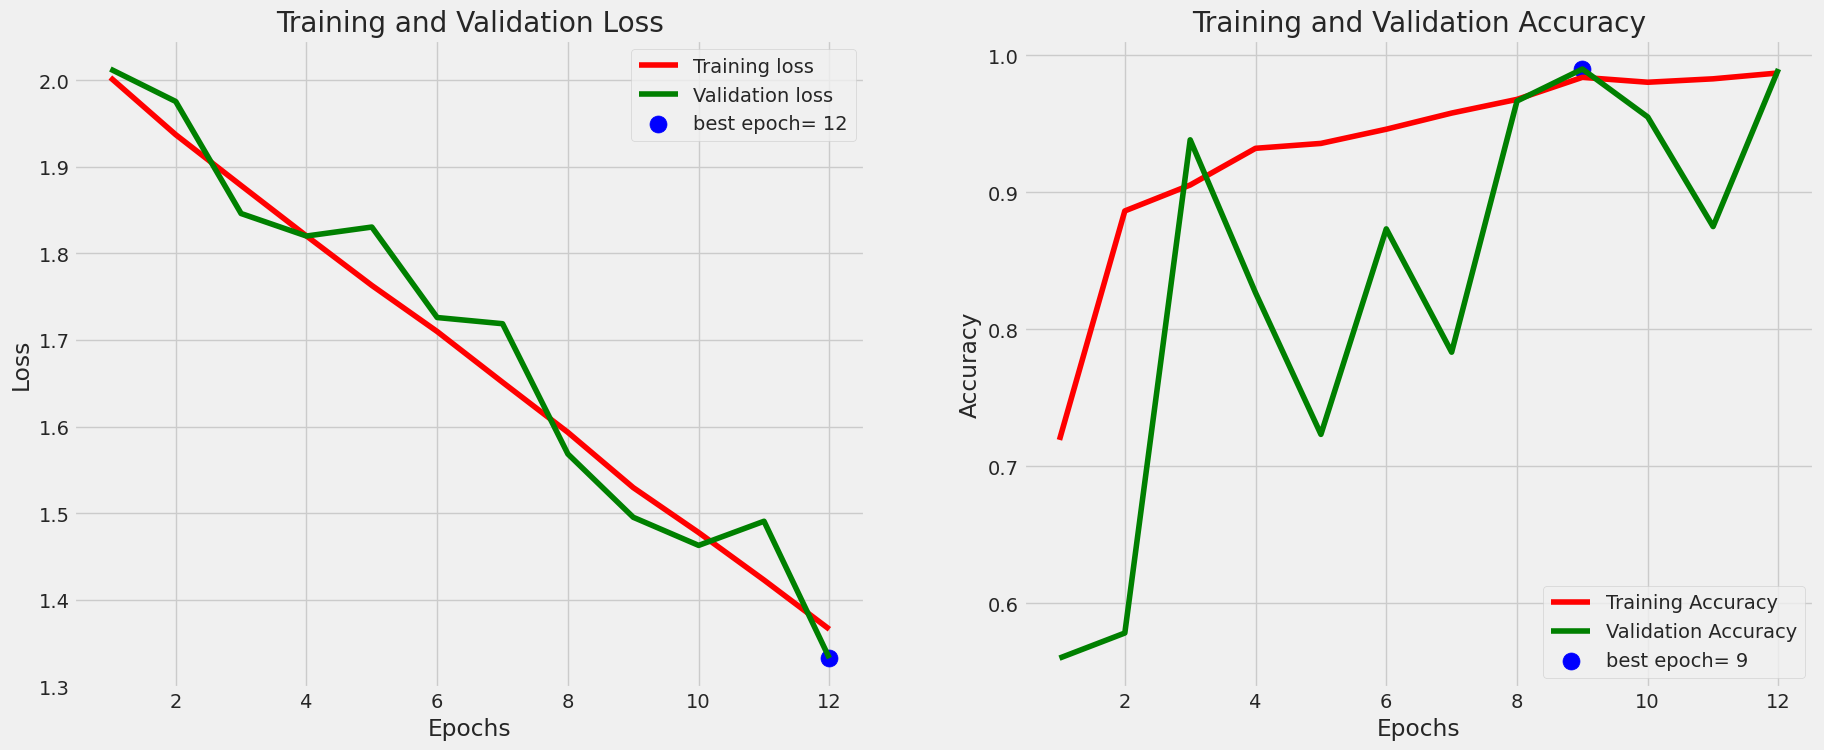

8/8 [==============================] - 10s 925ms/step - loss: 1.3325 - accuracy: 0.9933
Train Loss:  1.3243316411972046
Train Accuracy:  1.0
--------------------
Validation Loss:  1.3328146934509277
Validation Accuracy:  0.99609375
--------------------
Test Loss:  1.3325029611587524
Test Accuracy:  0.9933333396911621


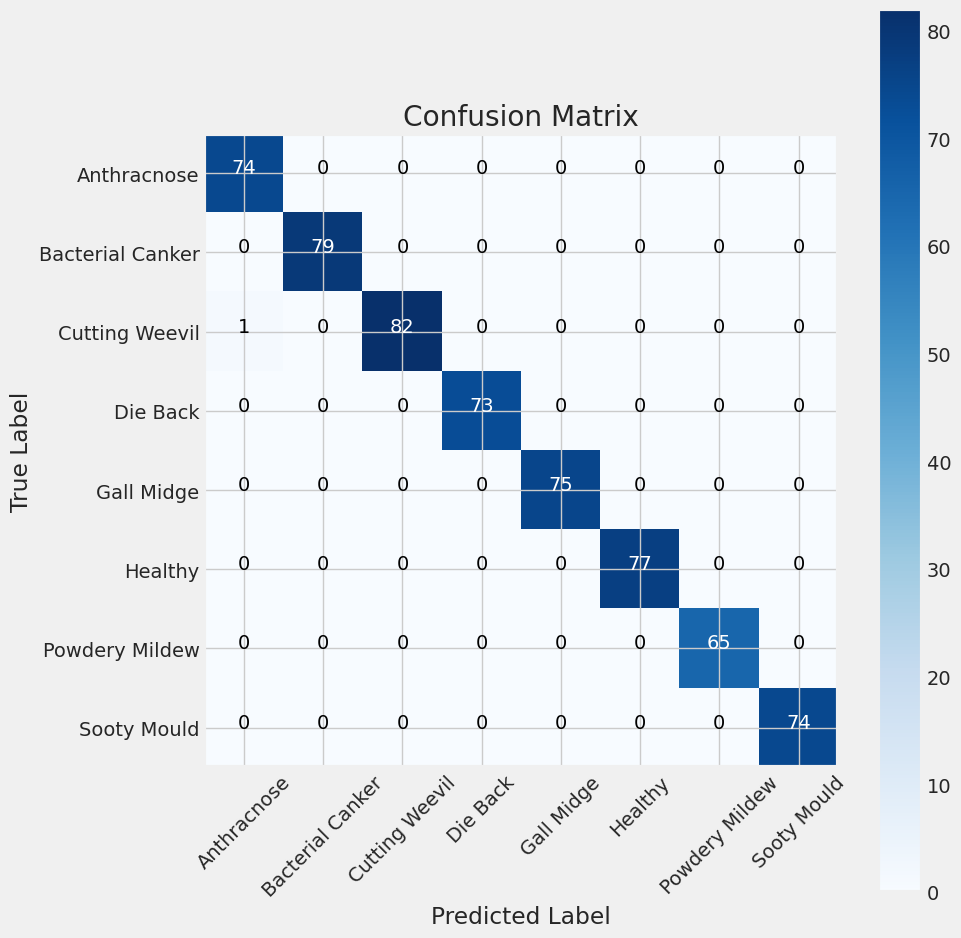

In [19]:

tr_acc = history_res.history['accuracy']
tr_loss = history_res.history['loss']
val_acc = history_res.history['val_accuracy']
val_loss = history_res.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_res.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model_res.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model_res.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
preds = model_res.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [22]:
print('GRADcam')

GRADcam


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [74]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [75]:
from tensorflow.keras.applications import EfficientNetB5

# Load the pre-trained EfficientNetB5 model
model = EfficientNetB5(weights='imagenet', include_top=False)

# Find the last convolutional layer
last_conv_layer = None
for layer in reversed(model.layers):
    if 'conv' in layer.name:
        last_conv_layer = layer
        break

print(last_conv_layer.name)

115263384/115263384 [==============================] - 1s 0us/step
top_conv


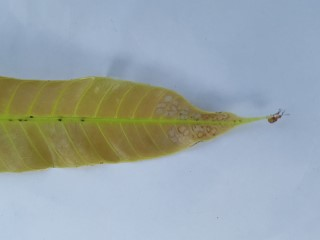

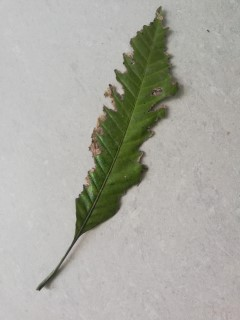

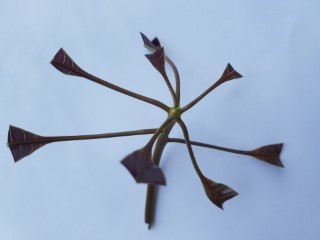

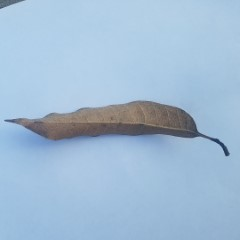

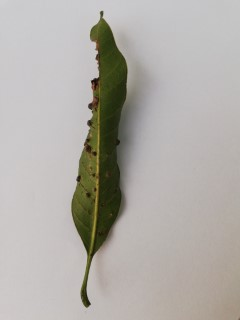

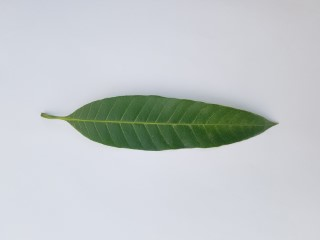

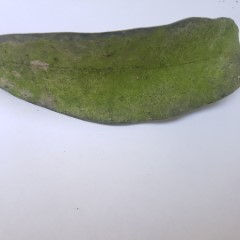

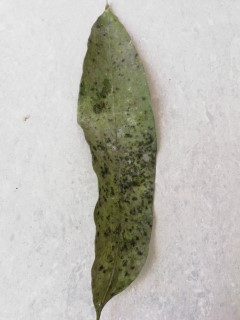

In [86]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB5, preprocess_input, decode_predictions
from IPython.display import Image, display

img_size = (456, 456)
last_conv_layer_name = "top_conv"

# The local path to our target image
paths = ['/kaggle/input/mango-leaf-disease-dataset/Anthracnose/20211008_124249 (Custom).jpg',
         '/kaggle/input/mango-leaf-disease-dataset/Bacterial Canker/IMG_20211106_120700 (Custom).jpg',
         '/kaggle/input/mango-leaf-disease-dataset/Cutting Weevil/20211011_131101 (Custom) (Custom).jpg',
         '/kaggle/input/mango-leaf-disease-dataset/Die Back/20211129_160425 (Custom).jpg',
         '/kaggle/input/mango-leaf-disease-dataset/Gall Midge/IMG_20211106_161058 (Custom).jpg',
         '/kaggle/input/mango-leaf-disease-dataset/Healthy/20211231_123105 (Custom).jpg',
         '/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/20211109_121158 (Custom).jpg',
         '/kaggle/input/mango-leaf-disease-dataset/Sooty Mould/IMG_20211108_120225 (Custom).jpg']

for img_path in paths:
    display(Image(img_path))

# Load the pre-trained EfficientNetB5 model
model_grad = model_builder(weights='imagenet', include_top=False)

# Find the last convolutional layer
last_conv_layer = model_grad.get_layer(last_conv_layer_name)
model_builder = tf.keras.applications.EfficientNetB5
img_size = (456, 456)
preprocess_input = keras.applications.efficientnet.preprocess_input
decode_predictions = keras.applications.efficientnet.decode_predictions



In [ ]:

    model_temp = model_builder(weights="imagenet")
    model_temp.fit(model.fit_generator( train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False))

In [87]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 37ms/step
Predicted: [('n01990800', 'isopod', 8.609211)]


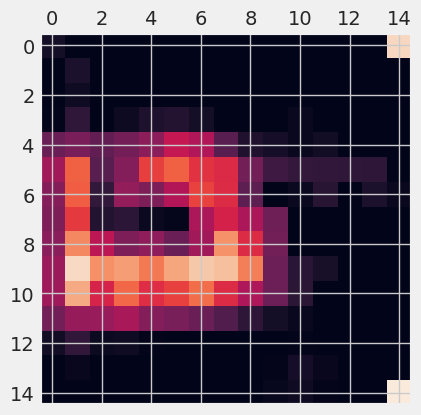

1/1 [==============================] - 0s 37ms/step
Predicted: [('n03991062', 'pot', 6.2335763)]


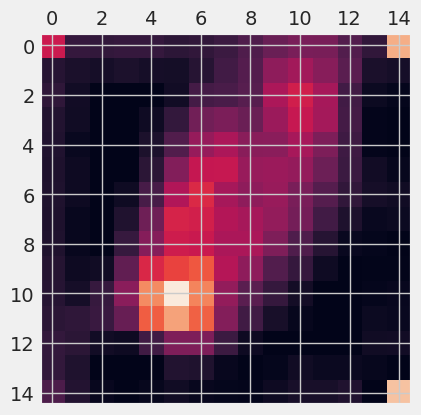

1/1 [==============================] - 0s 42ms/step
Predicted: [('n03498962', 'hatchet', 7.789339)]


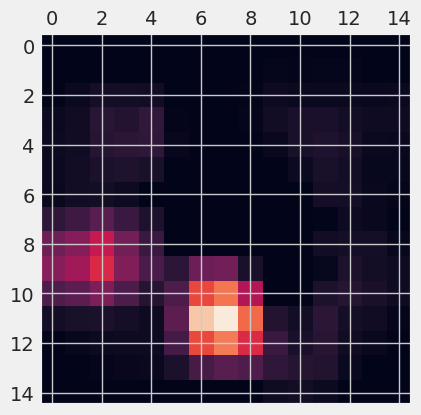

1/1 [==============================] - 0s 39ms/step
Predicted: [('n04033901', 'quill', 9.081905)]


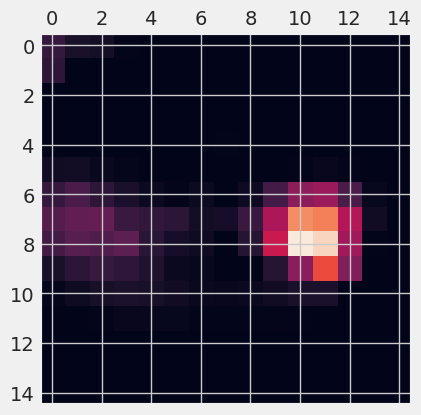

1/1 [==============================] - 0s 41ms/step
Predicted: [('n12267677', 'acorn', 6.929735)]


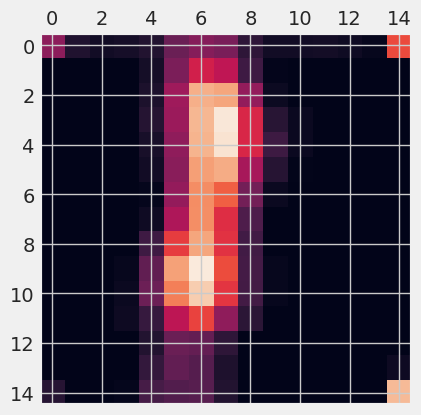

1/1 [==============================] - 0s 60ms/step
Predicted: [('n07753113', 'fig', 6.7141614)]


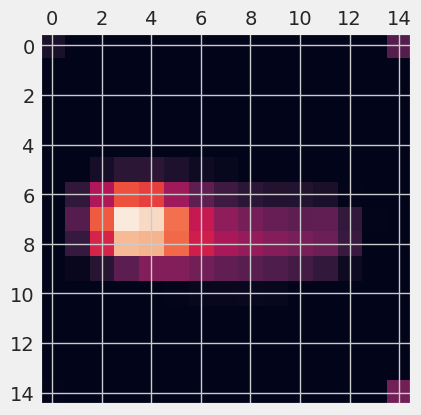

1/1 [==============================] - 0s 38ms/step
Predicted: [('n01924916', 'flatworm', 8.939553)]


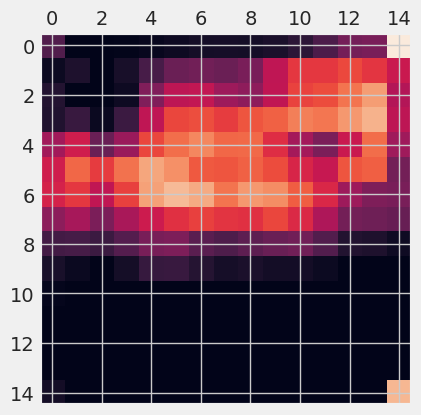

1/1 [==============================] - 0s 54ms/step
Predicted: [('n01924916', 'flatworm', 7.7081504)]


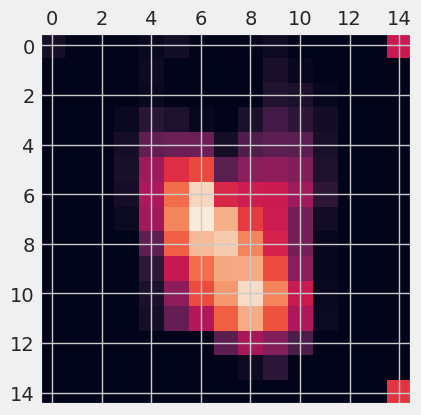

In [88]:
for img_path in paths:
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    print("Predicted:", decode_predictions(preds, top=1)[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model_temp, last_conv_layer_name)

    # Display heatmap
    plt.matshow(heatmap)
    plt.show()

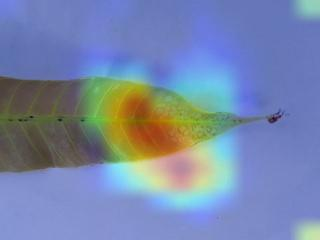

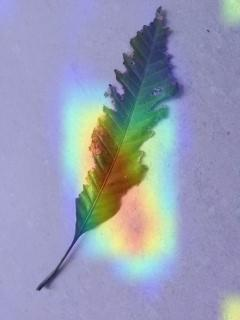

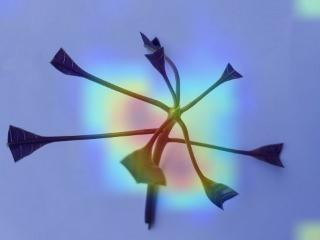

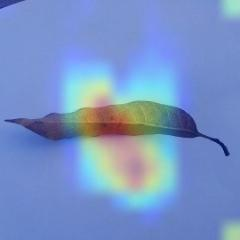

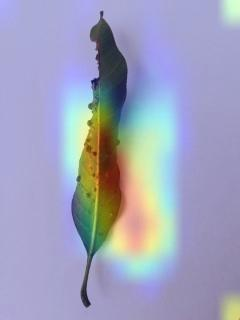

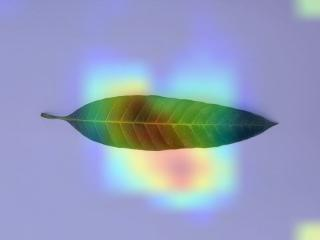

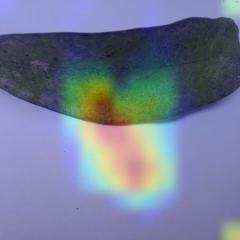

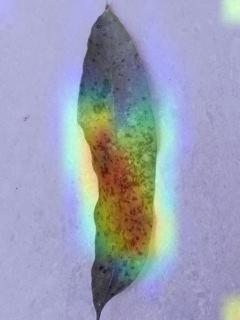

In [93]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

for img_path in paths:
    save_and_display_gradcam(img_path, heatmap)

In [105]:

model_ex = tf.keras.models.clone_model(
    model, input_tensors=None, clone_function=None
)

In [146]:
limeimage = [] 
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

  
    
    


In [150]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

1/1 [==============================] - 0s 41ms/step


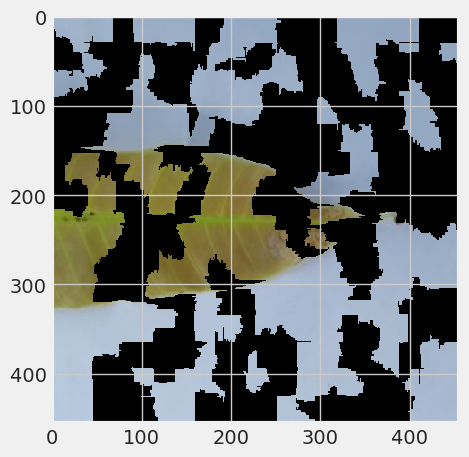

In [149]:
    img = Image('/kaggle/input/mango-leaf-disease-dataset/Anthracnose/20211008_124249 (Custom).jpg')
    img_path = '/kaggle/input/mango-leaf-disease-dataset/Anthracnose/20211008_124249 (Custom).jpg'
    np.random.seed(222)
    Xi = skimage.io.imread(img_path)
    Xi = skimage.transform.resize(Xi, (456,456)) 
    Xi = (Xi - 0.5)*2 #Inception pre-processing
    skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
    np.random.seed(222)
    preds = model.predict(Xi[np.newaxis,:,:,:])
    top_pred_classes = preds[0].argsort()[-5:][::-1]
    top_pred_classes 
    superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    num_superpixels
    skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))
    num_perturb = 150
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    perturbations[0] #Show example of perturbation
    skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi,pert,superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    predictions.shape
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    distances.shape
    num_top_features = 10
    top_features = np.argsort(coeff)[-num_top_features:] 
    top_features
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    weights.shape
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
    coeff
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    limeimage.append(perturb_image(Xi/2+0.5,mask,superpixels))

1/1 [==============================] - 0s 36ms/step


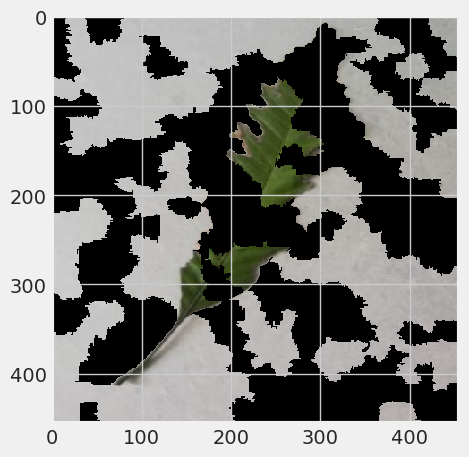

In [151]:
    img = Image('/kaggle/input/mango-leaf-disease-dataset/Bacterial Canker/IMG_20211106_120700 (Custom).jpg')
    img_path = '/kaggle/input/mango-leaf-disease-dataset/Bacterial Canker/IMG_20211106_120700 (Custom).jpg'
    np.random.seed(222)
    Xi = skimage.io.imread(img_path)
    Xi = skimage.transform.resize(Xi, (456,456)) 
    Xi = (Xi - 0.5)*2 #Inception pre-processing
    skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
    np.random.seed(222)
    preds = model.predict(Xi[np.newaxis,:,:,:])
    top_pred_classes = preds[0].argsort()[-5:][::-1]
    top_pred_classes 
    superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    num_superpixels
    skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))
    num_perturb = 150
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    perturbations[0] #Show example of perturbation
    skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi,pert,superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    predictions.shape
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    distances.shape
    num_top_features = 10
    top_features = np.argsort(coeff)[-num_top_features:] 
    top_features
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    weights.shape
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
    coeff
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    limeimage.append(perturb_image(Xi/2+0.5,mask,superpixels))

1/1 [==============================] - 0s 38ms/step


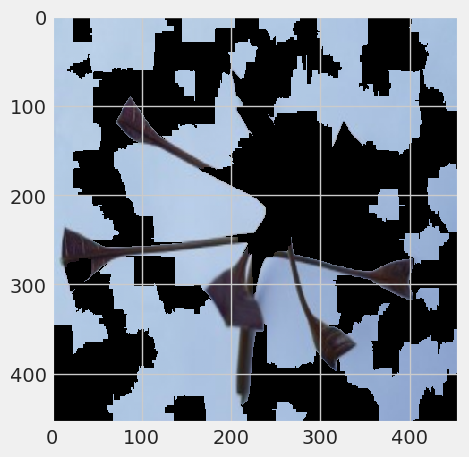

In [153]:
    img = Image('/kaggle/input/mango-leaf-disease-dataset/Cutting Weevil/20211011_131101 (Custom) (Custom).jpg')
    img_path = '/kaggle/input/mango-leaf-disease-dataset/Cutting Weevil/20211011_131101 (Custom) (Custom).jpg'
    np.random.seed(222)
    Xi = skimage.io.imread(img_path)
    Xi = skimage.transform.resize(Xi, (456,456)) 
    Xi = (Xi - 0.5)*2 #Inception pre-processing
    skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
    np.random.seed(222)
    preds = model.predict(Xi[np.newaxis,:,:,:])
    top_pred_classes = preds[0].argsort()[-5:][::-1]
    top_pred_classes 
    superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    num_superpixels
    skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))
    num_perturb = 150
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    perturbations[0] #Show example of perturbation
    skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi,pert,superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    predictions.shape
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    distances.shape
    num_top_features = 10
    top_features = np.argsort(coeff)[-num_top_features:] 
    top_features
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    weights.shape
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
    coeff
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    limeimage.append(perturb_image(Xi/2+0.5,mask,superpixels))

1/1 [==============================] - 0s 38ms/step


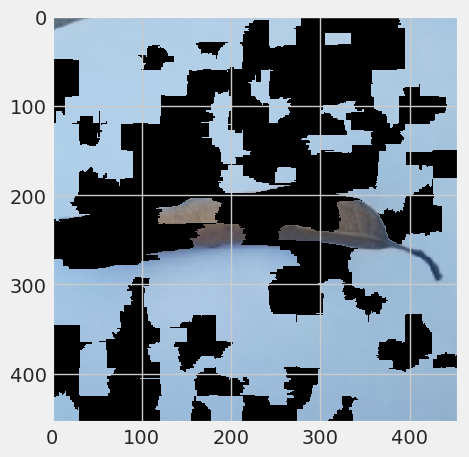

In [154]:
    img = Image('/kaggle/input/mango-leaf-disease-dataset/Die Back/20211129_160425 (Custom).jpg')
    img_path = '/kaggle/input/mango-leaf-disease-dataset/Die Back/20211129_160425 (Custom).jpg'
    np.random.seed(222)
    Xi = skimage.io.imread(img_path)
    Xi = skimage.transform.resize(Xi, (456,456)) 
    Xi = (Xi - 0.5)*2 #Inception pre-processing
    skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
    np.random.seed(222)
    preds = model.predict(Xi[np.newaxis,:,:,:])
    top_pred_classes = preds[0].argsort()[-5:][::-1]
    top_pred_classes 
    superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    num_superpixels
    skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))
    num_perturb = 150
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    perturbations[0] #Show example of perturbation
    skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi,pert,superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    predictions.shape
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    distances.shape
    num_top_features = 10
    top_features = np.argsort(coeff)[-num_top_features:] 
    top_features
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    weights.shape
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
    coeff
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    limeimage.append(perturb_image(Xi/2+0.5,mask,superpixels))

1/1 [==============================] - 0s 38ms/step


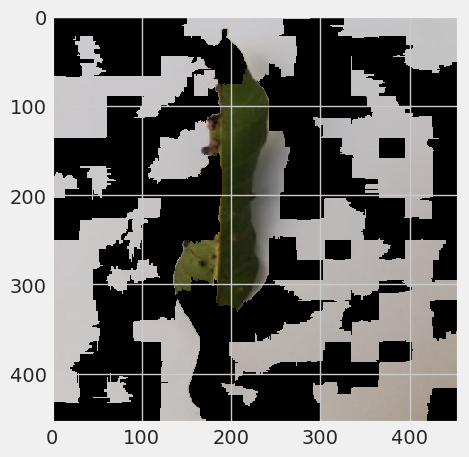

In [155]:
    img = Image('/kaggle/input/mango-leaf-disease-dataset/Gall Midge/IMG_20211106_161058 (Custom).jpg')
    img_path = '/kaggle/input/mango-leaf-disease-dataset/Gall Midge/IMG_20211106_161058 (Custom).jpg'
    np.random.seed(222)
    Xi = skimage.io.imread(img_path)
    Xi = skimage.transform.resize(Xi, (456,456)) 
    Xi = (Xi - 0.5)*2 #Inception pre-processing
    skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
    np.random.seed(222)
    preds = model.predict(Xi[np.newaxis,:,:,:])
    top_pred_classes = preds[0].argsort()[-5:][::-1]
    top_pred_classes 
    superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    num_superpixels
    skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))
    num_perturb = 150
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    perturbations[0] #Show example of perturbation
    skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi,pert,superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    predictions.shape
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    distances.shape
    num_top_features = 10
    top_features = np.argsort(coeff)[-num_top_features:] 
    top_features
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    weights.shape
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
    coeff
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    limeimage.append(perturb_image(Xi/2+0.5,mask,superpixels))

1/1 [==============================] - 0s 37ms/step


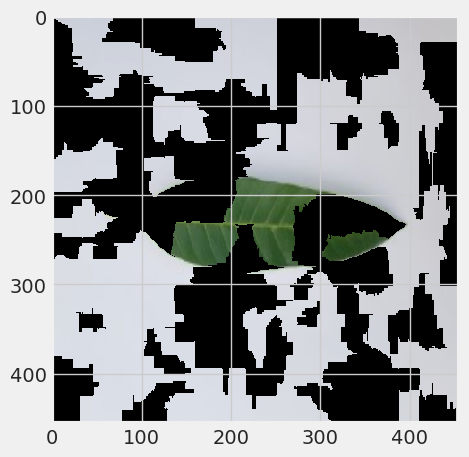

In [156]:
    img = Image('/kaggle/input/mango-leaf-disease-dataset/Healthy/20211231_123105 (Custom).jpg')
    img_path = '/kaggle/input/mango-leaf-disease-dataset/Healthy/20211231_123105 (Custom).jpg'
    np.random.seed(222)
    Xi = skimage.io.imread(img_path)
    Xi = skimage.transform.resize(Xi, (456,456)) 
    Xi = (Xi - 0.5)*2 #Inception pre-processing
    skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
    np.random.seed(222)
    preds = model.predict(Xi[np.newaxis,:,:,:])
    top_pred_classes = preds[0].argsort()[-5:][::-1]
    top_pred_classes 
    superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    num_superpixels
    skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))
    num_perturb = 150
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    perturbations[0] #Show example of perturbation
    skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi,pert,superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    predictions.shape
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    distances.shape
    num_top_features = 10
    top_features = np.argsort(coeff)[-num_top_features:] 
    top_features
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    weights.shape
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
    coeff
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    limeimage.append(perturb_image(Xi/2+0.5,mask,superpixels))

1/1 [==============================] - 0s 42ms/step


IndexError: index 164 is out of bounds for axis 0 with size 163

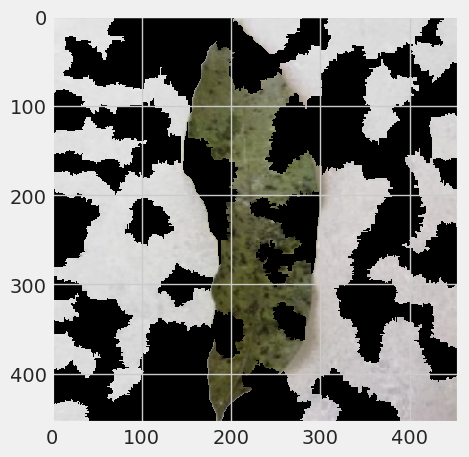

In [159]:
    img = Image('/kaggle/input/mango-leaf-disease-dataset/Sooty Mould/IMG_20211108_120225 (Custom).jpg')
    img_path = '/kaggle/input/mango-leaf-disease-dataset/Sooty Mould/IMG_20211108_120225 (Custom).jpg'
    np.random.seed(222)
    Xi = skimage.io.imread(img_path)
    Xi = skimage.transform.resize(Xi, (456,456)) 
    Xi = (Xi - 0.5)*2 #Inception pre-processing
    skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
    np.random.seed(222)
    preds = model.predict(Xi[np.newaxis,:,:,:])
    top_pred_classes = preds[0].argsort()[-5:][::-1]
    top_pred_classes 
    superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    num_superpixels
    skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))
    num_perturb = 150
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    perturbations[0] #Show example of perturbation
    skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi,pert,superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    predictions.shape
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    distances.shape
    num_top_features = 10
    top_features = np.argsort(coeff)[-num_top_features:] 
    top_features
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    weights.shape
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
    coeff
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    limeimage.append(perturb_image(Xi/2+0.5,mask,superpixels))

1/1 [==============================] - 0s 41ms/step


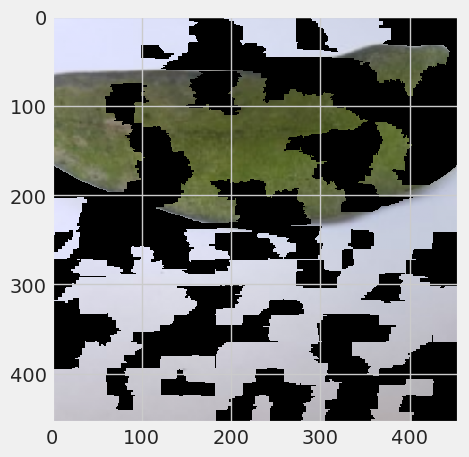

In [158]:
    img = Image('/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/20211109_121158 (Custom).jpg')
    img_path = '/kaggle/input/mango-leaf-disease-dataset/Powdery Mildew/20211109_121158 (Custom).jpg'
    np.random.seed(222)
    Xi = skimage.io.imread(img_path)
    Xi = skimage.transform.resize(Xi, (456,456)) 
    Xi = (Xi - 0.5)*2 #Inception pre-processing
    skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing
    np.random.seed(222)
    preds = model.predict(Xi[np.newaxis,:,:,:])
    top_pred_classes = preds[0].argsort()[-5:][::-1]
    top_pred_classes 
    superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    num_superpixels
    skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))
    num_perturb = 150
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    perturbations[0] #Show example of perturbation
    skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi,pert,superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    predictions.shape
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    distances.shape
    num_top_features = 10
    top_features = np.argsort(coeff)[-num_top_features:] 
    top_features
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    weights.shape
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
    coeff
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    limeimage.append(perturb_image(Xi/2+0.5,mask,superpixels))